In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3
mpld3.enable_notebook()
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

In [2]:
covid_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [3]:
covid_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,472,502,558,558,610,648,691,745,745,778
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,620,627,650,654,682,688,694,705,714,715
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2467,2546,2678,2841,2998,3058,3158,3271,3409,3507
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,537,545,550,550,568,576,596,604,615,617
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,11,13,13,13,13,14,14,17,17,17


In [4]:
covid_data.rename(columns={"Country/Region": "Location"}, inplace = True)

In [5]:
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

In [6]:
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

In [7]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [8]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

In [9]:
agegroups = agegroup_lookup["India"]
beds_per_100k = beds_lookup["India"]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [10]:
covid_india = covid_data[covid_data['Location'] == 'India']

In [11]:
covid_india.drop(['Province/State', 'Location' , 'Lat', 'Long'], axis=1, inplace = True)

In [12]:
data =covid_india.to_numpy()[0]

Text(0.5, 0, 'Date')

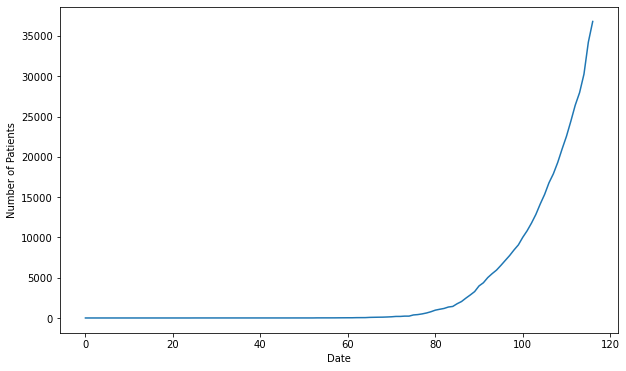

In [18]:
plt.figure(figsize=(10,6))
plt.plot(covid_india.to_numpy()[0])
plt.ylabel("Number of Patients")
plt.xlabel("Date")

In [13]:
data

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     4,     4,     4,     4,     4,    13,
          13,    14,    14,    15,    20,    23,    27,    27,    40,
          43,    45,    73,    84,    95,   102,   123,   148,   191,
         192,   229,   229,   375,   421,   506,   620,   774,   969,
        1080,  1181,  1359,  1432,  1768,  2041,  2463,  2854,  3273,
        3975,  4370,  5012,  5498,  5939,  6523,  7137,  7747,  8437,
        9068, 10007, 10819, 11775, 12847, 14142, 15331, 16776, 17887,
       19301, 20969, 22549, 24420, 26400, 27969, 30258, 34224, 36795],
      dtype=int64)

In [15]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array




def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[5][x]

In [16]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

{'R_0_start': 2.0000000000000004,
 'k': 4.897125786788932,
 'x0': 119.9968148982907,
 'R_0_end': 2.175280629009564,
 'prob_I_to_C': 0.010000000000000002,
 'prob_C_to_D': 0.7998481254951536,
 's': 0.003}

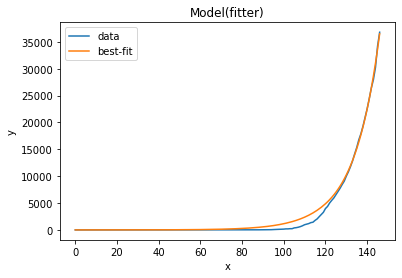

In [17]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-");
result.best_values